# Circles

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X, y = make_circles(1000, noise=0.03)

In [3]:
df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})

In [4]:
df.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

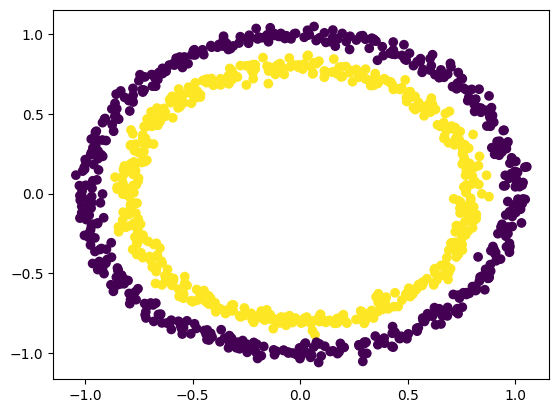

In [6]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y)

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2)

In [9]:
Xtr.shape, Xte.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

In [10]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.out = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        # x = self.out(x)
        # return x
        return self.out(self.relu(self.fc2(self.relu(self.fc1(x)))))

model = Model().to(device)
print(model)

Model(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [11]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.1)

In [12]:
def accuracy(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

In [13]:
Xtr, ytr = Xtr.to(device), ytr.to(device)
Xte, yte = Xte.to(device), yte.to(device)

In [14]:
epochs = 1000
torch.manual_seed(42)

for i in range(epochs):
    model.train()

    y_logits = model(Xtr).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilites -> pred labels

    loss = criterion(y_logits, ytr)
    acc = accuracy(y_pred, ytr)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(Xte).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = criterion(test_logits, yte)
        test_acc = accuracy(test_pred, yte)


    if i % 100 == 0:
        print(f"Epoch: {i} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70433, Accuracy: 50.50% | Test loss: 0.70561, Test acc: 48.00%
Epoch: 100 | Loss: 0.69072, Accuracy: 50.50% | Test loss: 0.68911, Test acc: 53.50%
Epoch: 200 | Loss: 0.68769, Accuracy: 52.25% | Test loss: 0.68734, Test acc: 56.00%
Epoch: 300 | Loss: 0.68450, Accuracy: 54.12% | Test loss: 0.68522, Test acc: 56.00%
Epoch: 400 | Loss: 0.68004, Accuracy: 54.25% | Test loss: 0.68213, Test acc: 51.00%
Epoch: 500 | Loss: 0.67348, Accuracy: 57.38% | Test loss: 0.67738, Test acc: 52.00%
Epoch: 600 | Loss: 0.66323, Accuracy: 61.88% | Test loss: 0.66913, Test acc: 55.50%
Epoch: 700 | Loss: 0.64590, Accuracy: 72.75% | Test loss: 0.65370, Test acc: 66.00%
Epoch: 800 | Loss: 0.61561, Accuracy: 85.50% | Test loss: 0.62553, Test acc: 79.00%
Epoch: 900 | Loss: 0.56285, Accuracy: 94.38% | Test loss: 0.57547, Test acc: 91.50%


In [15]:
model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model(Xte))).squeeze()
y_preds[:10], yte[:10]

(tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0.], device='cuda:0'),
 tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0.], device='cuda:0'))

# Blobs

In [16]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
NUM_FEATURES = 2
NUM_CLASSES = 4

In [21]:
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5)

X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_btr, X_bte, y_btr, y_bte = train_test_split(X_blob, y_blob, test_size=0.2)

tensor([[ 1.8131,  9.0829],
        [-9.0656,  5.8096],
        [ 1.2415, 11.0263],
        [11.7836, -4.4107],
        [11.7999, -0.8702]]) tensor([1, 2, 1, 3, 3])


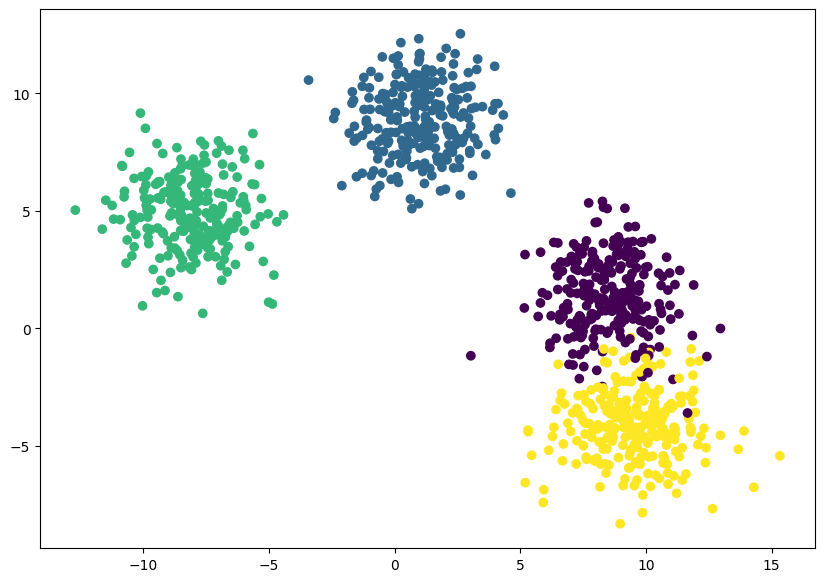

In [22]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)

In [23]:
class BlobModel(nn.Module):
    def __init__(self, input_features, out_features, hidden=8):
        super().__init__()
        self.lstack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=out_features),
        )

    def forward(self, x):
        return self.lstack(x)
    
model_b = BlobModel(input_features=NUM_FEATURES, out_features=NUM_CLASSES, hidden=10).to(device)
model_b

BlobModel(
  (lstack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_b.parameters(), lr=0.1)

In [25]:
X_btr, y_btr = X_btr.to(device), y_btr.to(device)
X_bte, y_bte = X_bte.to(device), y_bte.to(device)

In [26]:
epochs = 100

for i in range(epochs):
    model_b.train()

    y_logits = model_b(X_btr)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = criterion(y_logits, y_btr)
    acc = accuracy(y_true=y_btr, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_b.eval()
    with torch.inference_mode():
        test_logits = model_b(X_bte)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = criterion(test_logits, y_bte)
        test_acc = accuracy(y_true=y_bte, y_pred=test_pred)
    
    if i % 10 == 0:
        print(f"Epoch: {i} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.49186, Acc: 30.50% | Test Loss: 1.13737, Test Acc: 57.00%
Epoch: 10 | Loss: 0.44820, Acc: 96.75% | Test Loss: 0.39726, Test Acc: 95.50%
Epoch: 20 | Loss: 0.15504, Acc: 98.00% | Test Loss: 0.16416, Test Acc: 96.00%
Epoch: 30 | Loss: 0.09514, Acc: 98.00% | Test Loss: 0.11367, Test Acc: 96.00%
Epoch: 40 | Loss: 0.07574, Acc: 98.00% | Test Loss: 0.09663, Test Acc: 96.00%
Epoch: 50 | Loss: 0.06686, Acc: 98.00% | Test Loss: 0.08878, Test Acc: 96.00%
Epoch: 60 | Loss: 0.06200, Acc: 98.00% | Test Loss: 0.08447, Test Acc: 96.00%
Epoch: 70 | Loss: 0.05903, Acc: 98.00% | Test Loss: 0.08183, Test Acc: 96.00%
Epoch: 80 | Loss: 0.05706, Acc: 98.00% | Test Loss: 0.08007, Test Acc: 96.00%
Epoch: 90 | Loss: 0.05568, Acc: 97.88% | Test Loss: 0.07884, Test Acc: 96.00%


In [28]:
model_b.eval()
with torch.inference_mode():
    y_logits = model_b(X_bte)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_bte[:10]}")
print(f"Test accuracy: {accuracy(y_true=y_bte, y_pred=y_preds)}%")

Predictions: tensor([1, 0, 1, 0, 1, 1, 0, 2, 1, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 0, 2, 1, 0], device='cuda:0')
Test accuracy: 96.0%
